In [3]:
%load_ext autoreload
%autoreload 3

import sys
sys.path.append('../src/training-on-CM2.6')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import matplotlib as mpl
import cartopy.crs as ccrs

from helpers.plot_helpers import default_rcParams, set_letters

import warnings
warnings.filterwarnings("ignore")

# Reading 5-day average output of MOM6 in native vertical coordinates

In [2]:
control_simulation = xr.open_mfdataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/unparameterized/diagnostics/*ocean_3d*')
ann_simulation = xr.open_mfdataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/ANN/diagnostics/*ocean_3d*')

# Compute APE

In [3]:
# Select interfaces
eta_control = control_simulation.e
eta_ann = ann_simulation.e

# Reading reference height from time series data
Reference height is the height of the interface when it is adiabatically moved to the minimum of APE energy. It is part of MOM6 output

In [6]:
Z0 = -xr.open_dataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/unparameterized/diagnostics/ocean.stats.nc', decode_times=False).H0
reference_height_control = Z0[:-1].coarsen({'Time':20}).mean().drop_vars('Time').rename({'Time': 'time', 'Interface': 'zi'})
reference_height_control['time'] = control_simulation.time

In [7]:
Z0 = -xr.open_dataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/ANN/diagnostics/ocean.stats.nc', decode_times=False).H0
reference_height_ann = Z0[:-1].coarsen({'Time':20}).mean().drop_vars('Time').rename({'Time': 'time', 'Interface': 'zi'})
reference_height_ann['time'] = ann_simulation.time

# Read density structure of isopycnal layers and compute reduced gravities

In [8]:
TARGET_DENSITIES = xr.open_dataset('/scratch/pp2681/mom6/OM4_SIS2/zip-60-years/INPUT/layer_coord.nc').Layer

In [9]:
RHO0 = 1035. # reference density
GFS = 9.8 # acceleration at surface
G_prime = np.zeros(76) # reduced gravities in all vertical layers
G_prime[0] = GFS
G_prime[-1] = 0. # There is no energy of bottom layer
G_prime[1:-1] = GFS * np.diff(TARGET_DENSITIES) / RHO0
G_prime = xr.DataArray(G_prime, dims='zi')

In [10]:
print(G_prime.shape)
G_prime

(76,)


<xarray.DataArray (zi: 76)> Size: 608B
array([9.80000000e+00, 3.28844444e-02, 3.28844444e-02, 3.28844444e-02,
       3.28749758e-02, 3.28844444e-02, 3.20512077e-02, 7.07304348e-03,
       5.68115942e-03, 4.53545894e-03, 3.66434783e-03, 3.08676329e-03,
       2.71748792e-03, 2.45236715e-03, 2.30086957e-03, 2.19671498e-03,
       2.09256039e-03, 2.00734300e-03, 1.93159420e-03, 1.81797101e-03,
       1.72328502e-03, 1.63806763e-03, 1.53391304e-03, 1.43922705e-03,
       1.34454106e-03, 1.23091787e-03, 1.12676329e-03, 1.04154589e-03,
       9.56328502e-04, 8.80579710e-04, 8.23768116e-04, 7.57487923e-04,
       7.10144928e-04, 6.62801932e-04, 6.34396135e-04, 6.05990338e-04,
       5.87053140e-04, 5.68115942e-04, 5.58647343e-04, 5.39710145e-04,
       5.39710145e-04, 5.20772947e-04, 5.01835749e-04, 4.45024155e-04,
       3.88212560e-04, 3.50338164e-04, 3.12463768e-04, 2.74589372e-04,
       2.46183575e-04, 2.17777778e-04, 1.89371981e-04, 1.70434783e-04,
       1.60966184e-04, 1.42028986e-04, 1.32560386e-04, 1.23091787e-04,
       1.32560386e-04, 1.23091787e-04, 1.32560386e-04, 1.23091787e-04,
       1.23091787e-04, 1.32560386e-04, 1.23091787e-04, 1.42028986e-04,
       1.51497585e-04, 1.79903382e-04, 2.17777778e-04, 2.74589372e-04,
       3.97681159e-04, 5.49178744e-04, 6.72270531e-04, 8.52173913e-04,
       1.01314010e-03, 1.11729469e-03, 1.10782609e-03, 0.00000000e+00])
Dimensions without coordinates: zi

## APE computational function

In [11]:
def APE(interface, interface_rest, g):
    coordinate_of_bottom = interface.isel(zi=-1).drop_vars(['zi'])
    
    hint = interface - interface_rest
    
    # Where bottom is upper than the rest interface
    hbot = np.maximum(coordinate_of_bottom - interface_rest,0)
    
    APE_instant = (0.5 * g * (hint**2))
    APE_constant = (0.5 * g * (hbot**2))
    
    return (APE_instant - APE_constant)

In [12]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    APE_control = APE(eta_control, reference_height_control, G_prime).mean('time').compute()

[########################################] | 100% Completed | 84.88 ss


In [13]:
APE_control.to_netcdf('data/APE_control_OM4.nc')

In [14]:
with ProgressBar():
    APE_ann = APE(eta_ann, reference_height_ann, G_prime).mean('time').compute()

[########################################] | 100% Completed | 87.64 ss


In [15]:
APE_ann.to_netcdf('data/APE_ann_OM4.nc')

## Compare APE computed from 5-day averaged field to MOM6 time series output

In [63]:
param = xr.open_dataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/unparameterized/ocean_geometry.nc').rename({'lonh':'xh', 'lath':'yh', 'lonq': 'xq', 'latq': 'yq'})

In [53]:
APE_from_3d = (RHO0 * APE_control * param.dxT * param.dyT).sum(['xh', 'yh'])
APE_from_series = xr.open_dataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/unparameterized/diagnostics/ocean.stats.nc', decode_times=False).APE.mean('Time')

Text(0.5, 1.0, 'APE from series 3.906974E+20 \nAPE from 3d fields 3.907501E+20')

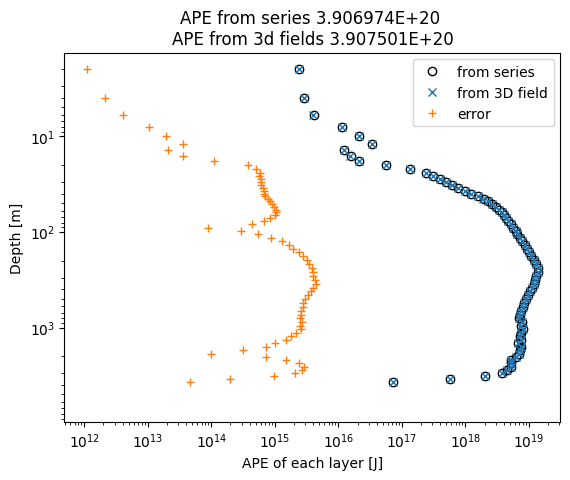

In [54]:
APE_from_series.plot(y='Interface', ls='', marker='o', markerfacecolor='none', color='k', label='from series')
APE_from_3d.plot(y='zi',ls='', marker='x', label='from 3D field')
np.abs(APE_from_series.values-APE_from_3d).plot(y='zi',ls='', marker='+', label='error')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('APE of each layer [J]')

plt.title('APE from series %E \nAPE from 3d fields %E' % (float(APE_from_series.sum()), float(APE_from_3d.sum())))

In [55]:
APE_from_3d = (RHO0 * APE_ann * param.dxT * param.dyT).sum(['xh', 'yh'])
APE_from_series = xr.open_dataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/ANN/diagnostics/ocean.stats.nc', decode_times=False).APE.mean('Time')

Text(0.5, 1.0, 'APE from series 3.638570E+20 \nAPE from 3d fields 3.638752E+20')

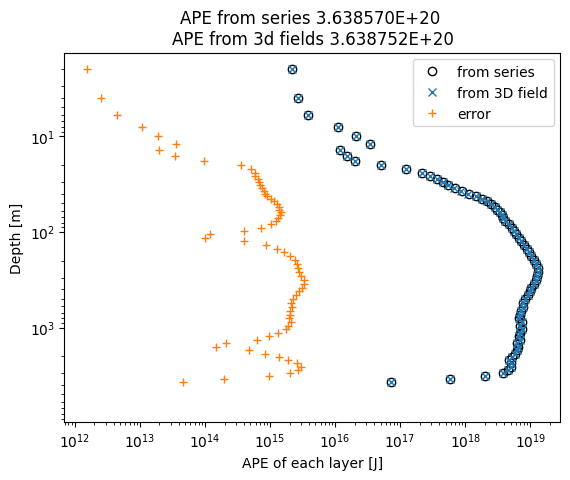

In [56]:
APE_from_series.plot(y='Interface', ls='', marker='o', markerfacecolor='none', color='k', label='from series')
APE_from_3d.plot(y='zi',ls='', marker='x', label='from 3D field')
np.abs(APE_from_series.values-APE_from_3d).plot(y='zi',ls='', marker='+', label='error')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('APE of each layer [J]')
plt.title('APE from series %E \nAPE from 3d fields %E' % (float(APE_from_series.sum()), float(APE_from_3d.sum())))

# Compute EKE, KE, MKE

In [4]:
import xgcm
param = xr.open_dataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/unparameterized/ocean_geometry.nc').rename({'lonh':'xh', 'lath':'yh', 'lonq': 'xq', 'latq': 'yq'})
grid = xgcm.Grid(param, coords={
            'X': {'center': 'xh', 'right': 'xq'},
            'Y': {'center': 'yh', 'right': 'yq'}
        },
        boundary={"X": 'periodic', 'Y': 'fill'},
        fill_value = {'Y':0})

In [14]:
def kinetic_energy(data):
    data = data.chunk({'zl':1})
    h = (data.e.isel(zi=slice(0,-1)).drop_vars('zi') - data.e.isel(zi=slice(1,None)).drop_vars('zi')).rename({'zi': 'zl'})
    out = xr.Dataset()

    # Time-averaged kinetic energy
    KEu = 0.5 * (data.uo**2 * grid.interp(h,'X')).chunk({'yh':100}).mean('time').compute()
    KEv = 0.5 * (data.vo**2 * grid.interp(h,'Y')).chunk({'xh':100}).mean('time').compute()
    
    out['KE'] = (grid.interp(KEu,'X') + grid.interp(KEv,'Y'))

    # Mean velocity and thickness
    uom = data.uo.chunk({'yh':100}).mean('time').compute()
    vom = data.vo.chunk({'yq':100}).mean('time').compute()
    hm = h.chunk({'yh':100}).mean('time').compute()

    # MKE
    KEu = 0.5 * uom**2 * grid.interp(hm,'X')
    KEv = 0.5 * vom**2 * grid.interp(hm,'Y')

    out['MKE'] = (grid.interp(KEu,'X') + grid.interp(KEv,'Y'))

    out['EKE'] = out['KE'] - out['MKE']

    return out

In [15]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    energy_control = kinetic_energy(control_simulation)

[########################################] | 100% Completed | 72.74 s
[########################################] | 100% Completed | 85.11 s
[########################################] | 100% Completed | 38.66 s
[########################################] | 100% Completed | 30.81 s
[########################################] | 100% Completed | 44.70 s


In [36]:
energy_control.astype('float32').to_netcdf('data/KE_control_OM4.nc')

In [27]:
RHO0 = 1035.
KE_from_series = xr.open_dataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/unparameterized/diagnostics/ocean.stats.nc', decode_times=False).KE.mean('Time')
KE_from_3d = KE_from_series*0 + (RHO0 * energy_control.KE * param.dxT * param.dyT).sum(['xh', 'yh']).values

Text(0.5, 1.0, 'KE from series 2.745105E+18 \nKE from 3d fields 2.574830E+18')

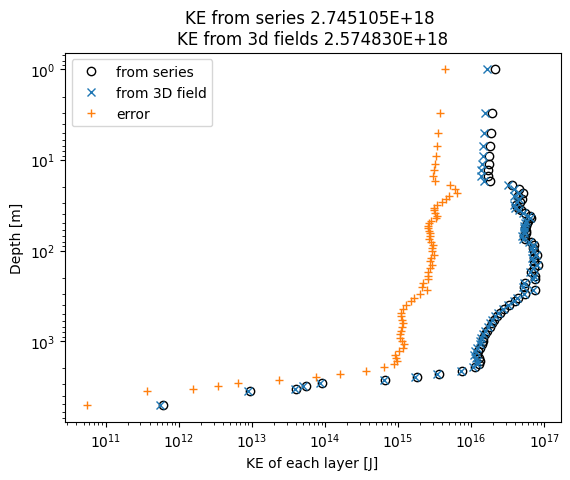

In [29]:
KE_from_series.plot(y='Layer', ls='', marker='o', markerfacecolor='none', color='k', label='from series')
KE_from_3d.plot(y='Layer',ls='', marker='x', label='from 3D field')
np.abs(KE_from_series-KE_from_3d).plot(y='Layer',ls='', marker='+', label='error')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('KE of each layer [J]')
plt.title('KE from series %E \nKE from 3d fields %E' % (float(KE_from_series.sum()), float(KE_from_3d.sum())))

In [30]:
with ProgressBar():
    energy_ann = kinetic_energy(ann_simulation)

[########################################] | 100% Completed | 72.61 s
[########################################] | 100% Completed | 87.26 s
[########################################] | 100% Completed | 37.68 s
[########################################] | 100% Completed | 31.76 s
[########################################] | 100% Completed | 45.10 s


In [35]:
energy_ann.astype('float32').to_netcdf('data/KE_ann_OM4.nc')

In [31]:
RHO0 = 1035.
KE_from_series = xr.open_dataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/ANN/diagnostics/ocean.stats.nc', decode_times=False).KE.mean('Time')
KE_from_3d = KE_from_series*0 + (RHO0 * energy_ann.KE * param.dxT * param.dyT).sum(['xh', 'yh']).values

Text(0.5, 1.0, 'KE from series 3.971467E+18 \nKE from 3d fields 3.768368E+18')

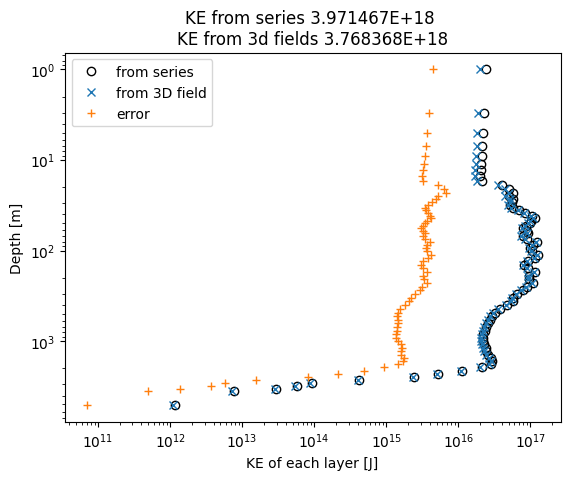

In [32]:
KE_from_series.plot(y='Layer', ls='', marker='o', markerfacecolor='none', color='k', label='from series')
KE_from_3d.plot(y='Layer',ls='', marker='x', label='from 3D field')
np.abs(KE_from_series-KE_from_3d).plot(y='Layer',ls='', marker='+', label='error')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('KE of each layer [J]')
plt.title('KE from series %E \nKE from 3d fields %E' % (float(KE_from_series.sum()), float(KE_from_3d.sum())))

# Save 2d fields for lon-term storage

In [ ]:
KE_control = xr.open_mfdataset('data/KE_control_OM4.nc').sum('zl').compute()
KE_ann = xr.open_mfdataset('data/KE_ann_OM4.nc').sum('zl').compute()

APE_control = xr.open_mfdataset('data/APE_control_OM4.nc').__xarray_dataarray_variable__.sum('zi').compute()
APE_ann = xr.open_mfdataset('data/APE_ann_OM4.nc').__xarray_dataarray_variable__.sum('zi').compute()

from dask.diagnostics import ProgressBar
with ProgressBar():
    dEdt = xr.open_mfdataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/ANN/diagnostics/*budget*').KE_ZB2020.sum('zl').mean('time').compute()

In [6]:
KE_control.to_netcdf('data/KE_control_OM4.nc')
KE_ann.to_netcdf('data/KE_ann_OM4.nc')
APE_control.to_netcdf('data/APE_control_OM4.nc')
APE_ann.to_netcdf('data/APE_ann_OM4.nc')
dEdt.to_netcdf('data/dEdt_OM4.nc')

# Figure 3

In [4]:
KE_control = xr.open_dataset('data/KE_control_OM4.nc')
KE_ann = xr.open_dataset('data/KE_ann_OM4.nc')

APE_control = xr.open_dataset('data/APE_control_OM4.nc').__xarray_dataarray_variable__
APE_ann = xr.open_dataset('data/APE_ann_OM4.nc').__xarray_dataarray_variable__
dEdt = xr.open_dataset('data/dEdt_OM4.nc').KE_ZB2020

param = xr.open_dataset('/home/pp2681/global-runs/data/ocean_static.nc')
mask_nan = param.wet.where(param.wet).compute()

# We consider basincode 1,2,3,4,5 which are five oceans

In [6]:
from cmip_basins import generate_basin_codes

In [7]:
basincodes = generate_basin_codes(param, lon='geolon', lat='geolat', mask='wet')

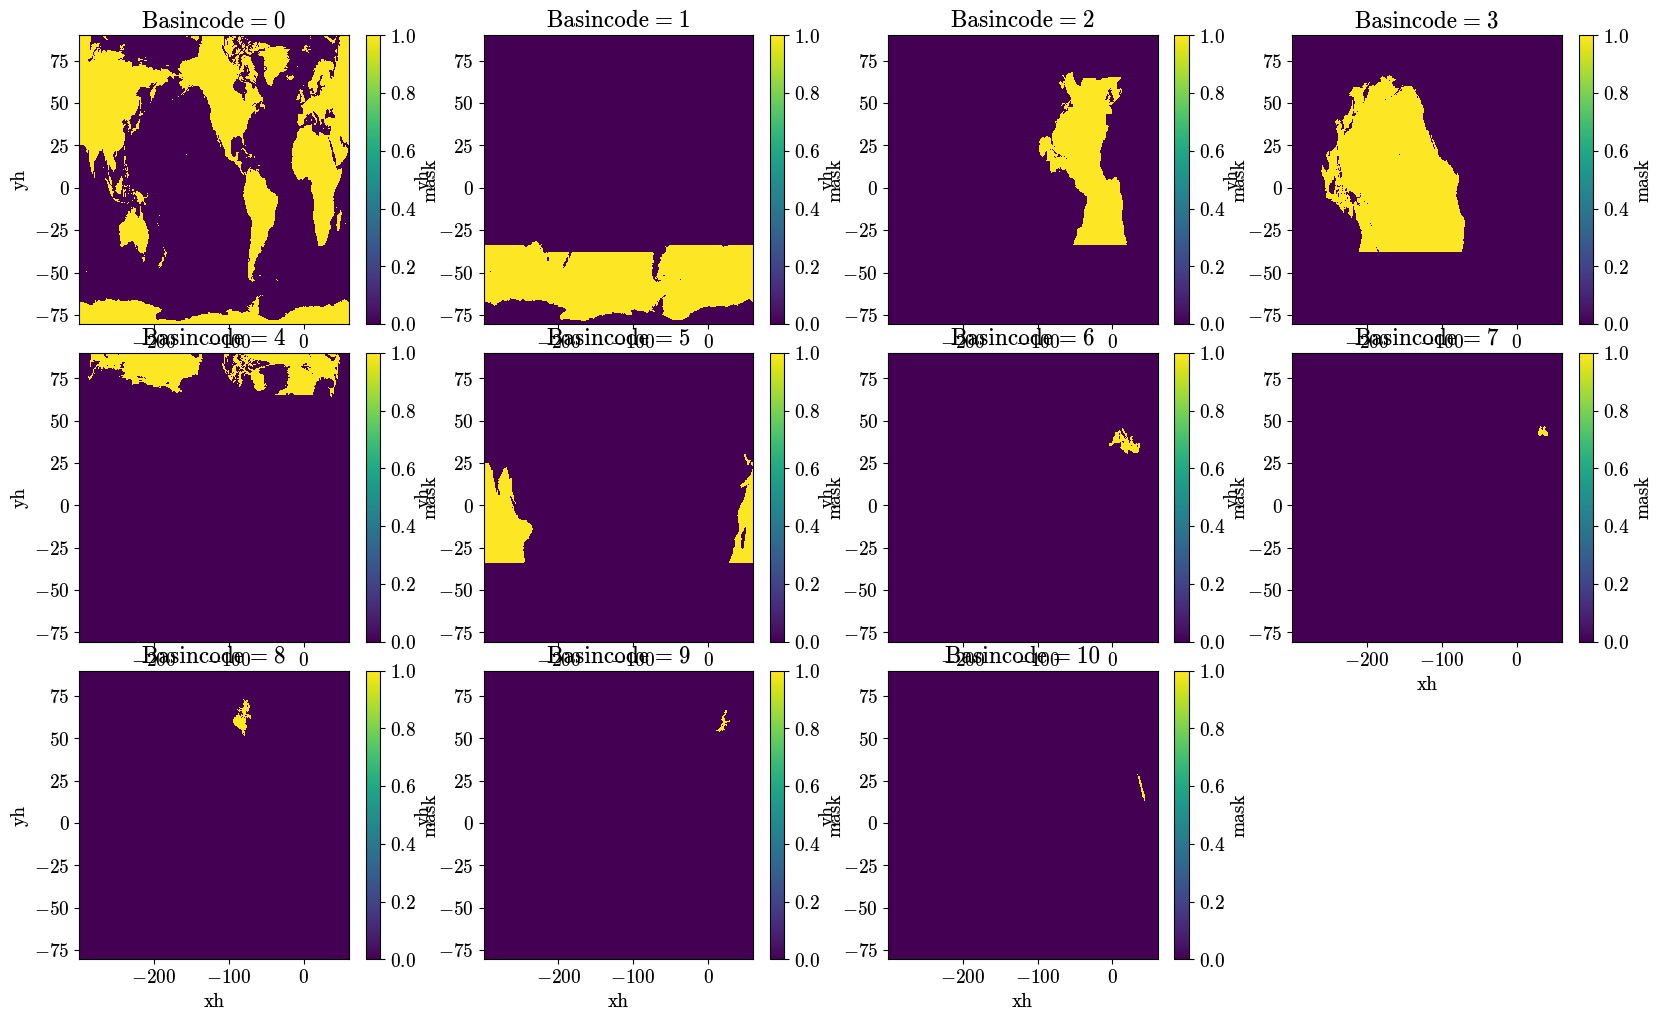

In [115]:
plt.figure(figsize=(20,12))
for i in range(11):
    plt.subplot(3,4,i+1)
    (basincodes==i).plot()
    plt.title(f'Basincode = {i}')

# Compute percentage of EKE change

1970178.2
3077280.2


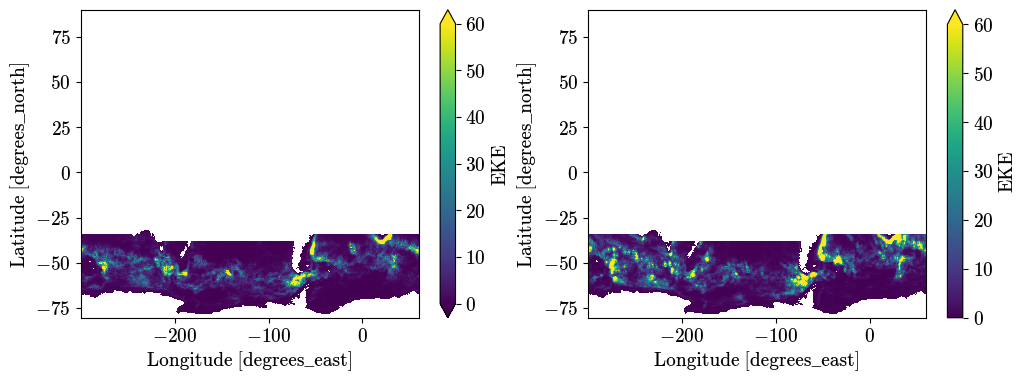

In [103]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
(KE_control['EKE']).where(basincodes==1).plot(vmin=0, vmax=60)
plt.subplot(1,2,2)
(KE_ann['EKE']).where(basincodes==1).plot(vmin=0, vmax=60)
print(KE_control['EKE'].where(basincodes==1).sum().data)
print(KE_ann['EKE'].where(basincodes==1).sum().data)

In [104]:
(307-197)/197.

0.5583756345177665

In [8]:
rho0 = 1035.
percentage_EKE_change = {}
percentage_APE_change = {}
for basin in [1,2,3,4,5]:
    EKE_control_value = rho0 * (param.areacello * KE_control['EKE']).where(basincodes==basin).sum() # Joules
    EKE_ann_value     = rho0 * (param.areacello * KE_ann['EKE']).where(basincodes==basin).sum() # Joules
    percentage_EKE_change[basin] = round(float((EKE_ann_value - EKE_control_value) / EKE_control_value * 100.), 0)

    APE_control_value = rho0 * (param.areacello * APE_control).where(basincodes==basin).sum() # Watt
    APE_ann_value     = rho0 * (param.areacello * APE_ann).where(basincodes==basin).sum() # Watt
    percentage_APE_change[basin] = round(float((APE_ann_value - APE_control_value) / APE_control_value * 100.), 1)

In [9]:
percentage_EKE_change

{1: 69.0, 2: 52.0, 3: 61.0, 4: -7.0, 5: 53.0}

In [10]:
percentage_APE_change

{1: -12.1, 2: -7.8, 3: 0.7, 4: -2.2, 5: 0.2}

# Here we move boundaries of the mask in order to avoid overlapping of contours

In [149]:
# import xgcm
# grid = xgcm.Grid(param, coords={
#             'X': {'center': 'xh', 'right': 'xq'},
#             'Y': {'center': 'yh', 'right': 'yq'}
#         },
#         boundary={"X": 'periodic', 'Y': 'fill'},
#         fill_value = {'Y':0})
# def propagate_boundary_mask(mask, niters=3):
#     for i in range(niters):
#         mask = grid.interp(grid.interp(mask.astype('float32'), ['X','Y']), ['X','Y'])
#     return mask==1.

In [150]:
# plt.figure(figsize=(12,4))
# plt.subplot(1,3,1)
# (basincodes==2).plot()
# plt.subplot(1,3,2)
# propagate_boundary_mask(basincodes==2).plot()
# plt.subplot(1,3,3)
# (propagate_boundary_mask(basincodes==2).astype('float32') - (basincodes==2).astype('float32')).plot()

# Plotting figure

Colorbar-like object skipped
Colorbar-like object skipped
Colorbar-like object skipped


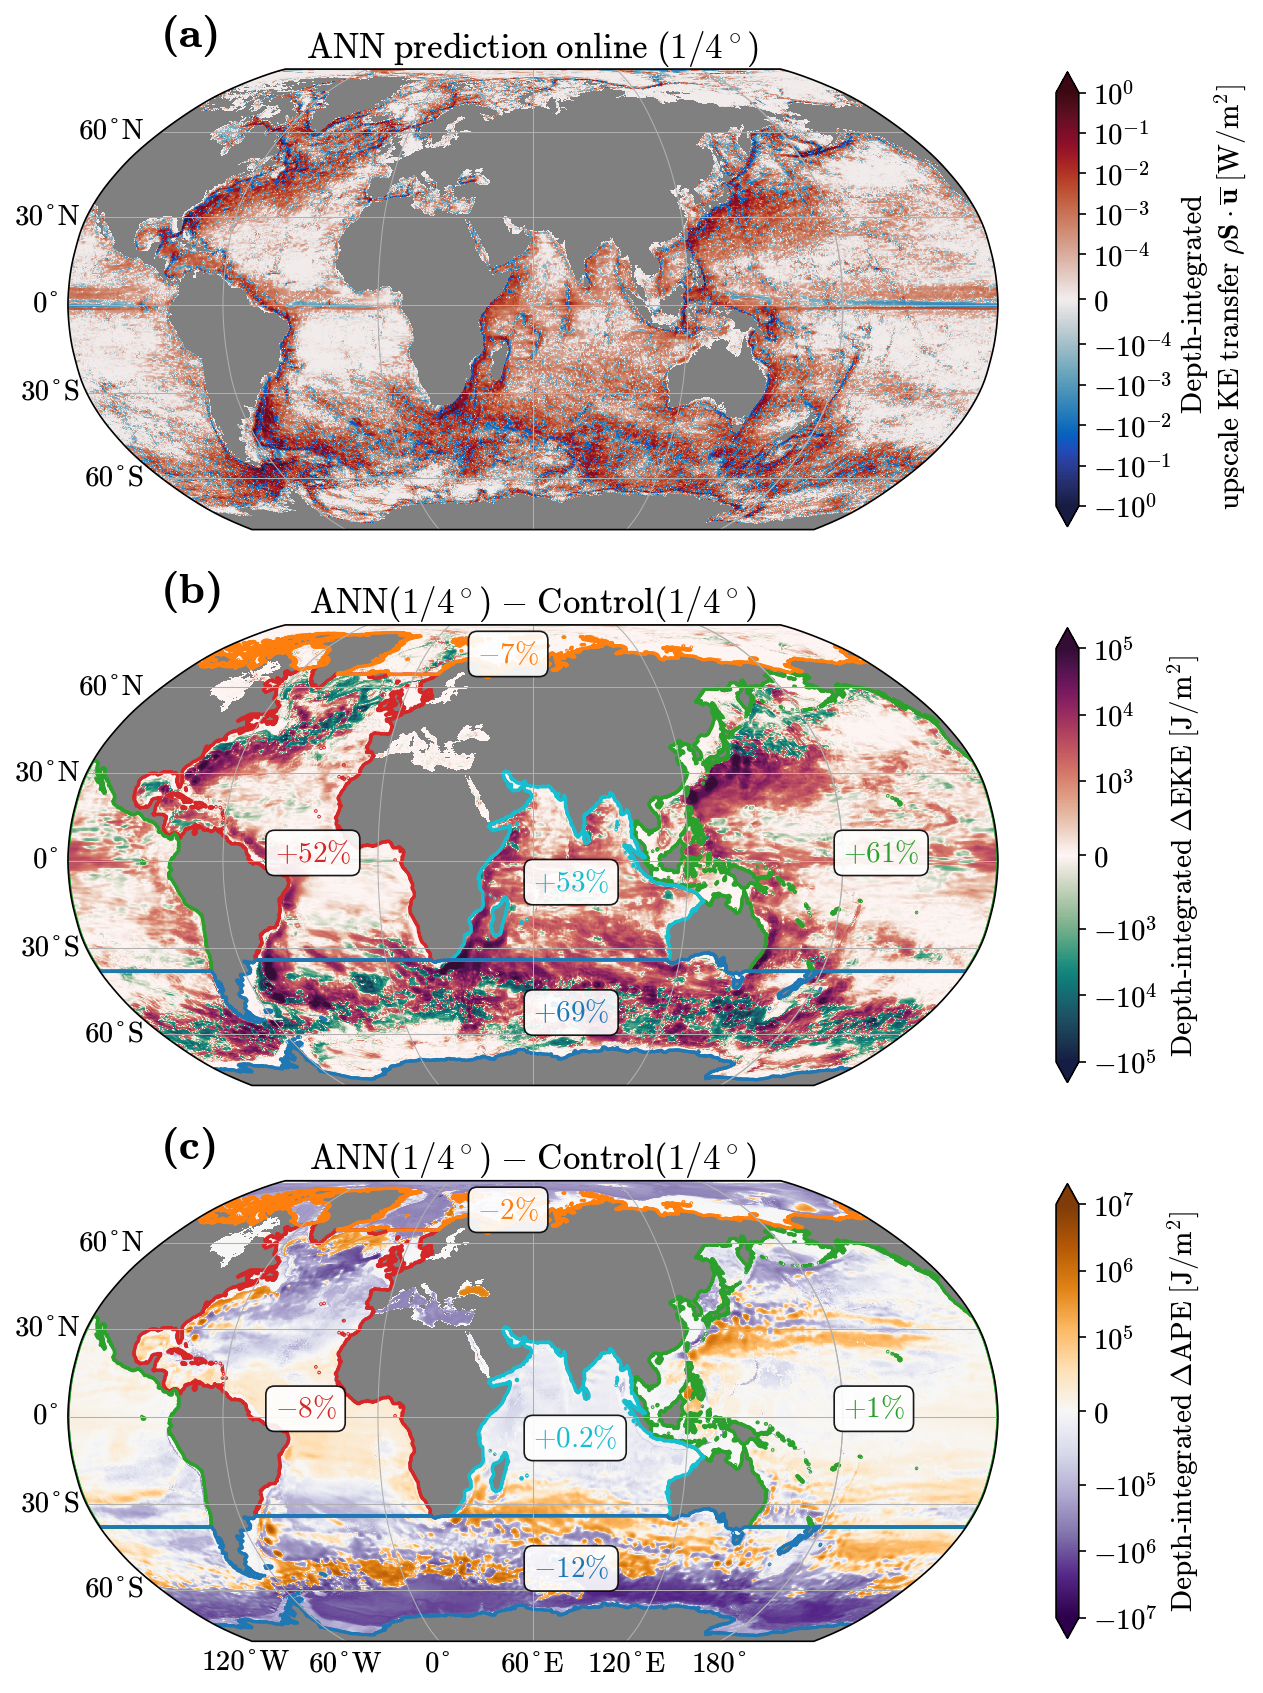

In [18]:
default_rcParams({'font.size':14, 'figure.subplot.hspace':0.1})
rho0 = 1035.

fig, axes = plt.subplots(
    nrows=3, ncols=1,
    figsize=(10, 14),
    subplot_kw={'projection':ccrs.Robinson(central_longitude=60)},
    dpi=150
)

ax = axes[0]
im = ax.pcolormesh(param.geolon, param.geolat, mask_nan * rho0*(dEdt), 
                   cmap=cmocean.cm.balance,
                   norm=mpl.colors.SymLogNorm(vmin = -1, vmax = 1, linthresh = 1e-4),
                   transform=ccrs.PlateCarree(), rasterized=True)
plt.colorbar(im, ax=ax, label='Depth-integrated \n upscale KE transfer $\\rho \\mathbf{S} \\cdot \\overline{\\mathbf{u}}$ [W/m$^2$]', shrink=0.9,extend='both')
ax.set_title('ANN prediction online ($1/4^\circ$)')
ax.set_facecolor('gray')
gl = ax.gridlines(draw_labels=True, linewidth=0.5,alpha=1.0, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False


ax = axes[1]
im = ax.pcolormesh(param.geolon, param.geolat, mask_nan * rho0*(KE_ann['EKE'] - KE_control['EKE']), 
                   cmap=cmocean.cm.curl, norm=mpl.colors.SymLogNorm(vmin = -1e+5, vmax = 1e+5, linthresh = 1e+3),
                   transform=ccrs.PlateCarree(), rasterized=True)
plt.colorbar(im, ax=ax, label='Depth-integrated $\Delta$EKE [J/m$^2$]', shrink=0.9,extend='both')
ax.set_title('ANN($1/4^\circ$) $-$ Control($1/4^\circ$)')
ax.set_facecolor('gray')
#ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=0.5,alpha=1.0, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
for code, color in zip([2,3,5,4,1], ['tab:red', 'tab:green', 'tab:cyan',  'tab:orange', 'tab:blue']):
    mask = (basincodes==code)
    cs = ax.contour(param.geolon, param.geolat, mask, levels=1, colors=color, linewidths=1.5, transform=ccrs.PlateCarree(), rasterized=True)
    cs.set_rasterized(True)
bbox = dict(
        facecolor='white',      # Background color
        edgecolor='black',      # Border color
        boxstyle='round,pad=0.3',  # Rounded box with padding
        linewidth=0.8,
        alpha=0.9               # Slight transparency (optional)
    )
ax.text(60,-55,'$+69\%$', transform=ccrs.PlateCarree(), color='tab:blue', bbox=bbox)
ax.text(-40,0,'$+52\%$', transform=ccrs.PlateCarree(), color='tab:red', bbox=bbox)
ax.text(180,0,'$+61\%$', transform=ccrs.PlateCarree(), color='tab:green', bbox=bbox)
ax.text(30,70,'$-7\%$', transform=ccrs.PlateCarree(), color='tab:orange', bbox=bbox)
ax.text(60,-10,'$+53\%$', transform=ccrs.PlateCarree(), color='tab:cyan', bbox=bbox)
    
ax = axes[2]
im = ax.pcolormesh(param.geolon, param.geolat, mask_nan * rho0*(APE_ann - APE_control), 
                   cmap=plt.cm.PuOr_r, norm=mpl.colors.SymLogNorm(vmin = -1e+7, vmax = 1e+7, linthresh = 1e+5),
                   transform=ccrs.PlateCarree(), rasterized=True)
plt.colorbar(im, ax=ax, label='Depth-integrated $\Delta$APE [J/m$^2$]', shrink=0.9,extend='both')
ax.set_title('ANN($1/4^\circ$) $-$ Control($1/4^\circ$)')
ax.set_facecolor('gray')
#ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=0.5,alpha=1.0, linestyle='-')
gl.top_labels = False
gl.right_labels = False

for code, color in zip([2,3,5,4,1], ['tab:red', 'tab:green', 'tab:cyan',  'tab:orange', 'tab:blue']):
    mask = (basincodes==code)
    cs = ax.contour(param.geolon, param.geolat, mask, levels=1, colors=color, linewidths=1.5, transform=ccrs.PlateCarree(), rasterized=True)
    cs.set_rasterized(True)
bbox = dict(
        facecolor='white',      # Background color
        edgecolor='black',      # Border color
        boxstyle='round,pad=0.3',  # Rounded box with padding
        linewidth=0.8,
        alpha=0.9               # Slight transparency (optional)
    )
ax.text(60,-55,'$-12\%$', transform=ccrs.PlateCarree(), color='tab:blue', bbox=bbox)
ax.text(-40,0,'$-8\%$', transform=ccrs.PlateCarree(), color='tab:red', bbox=bbox)
ax.text(180,0,'$+1\%$', transform=ccrs.PlateCarree(), color='tab:green', bbox=bbox)
ax.text(30,70,'$-2\%$', transform=ccrs.PlateCarree(), color='tab:orange', bbox=bbox)
ax.text(60,-10,'$+0.2\%$', transform=ccrs.PlateCarree(), color='tab:cyan', bbox=bbox)

set_letters(fontsize=20, x=0.1)

plt.savefig('figures/Figure3-precentage.pdf', dpi=150)